# Use ICA rather than PCA

1. plot the joint distribution of different combination of variables when sliding the time window

# 1. Load the data

# 

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from base import MultiDaysBeaconPosition, BeaconPosition
from scipy.stats import sem
from utils.basic_utils import get_tags, joint_density_function
from utils.pca_method import generate_tau_sample
from sklearn.decomposition import PCA

from utils.baseline_method import continuous_detection 

In [2]:
root_path = '../Data/Raw/'
rat_id = 'FS10'
rat_subdirectories = glob(root_path+rat_id+'/*/' )

tags = get_tags(rat_subdirectories)

## 1.1 For one tag of rat

In [3]:
tag_id = 0
this_tag = BeaconPosition(rat_subdirectories[tag_id], tags[tag_id], True, True) #position data of this tag

In [4]:
unit_time = np.mean(this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
print(unit_time) # average time for a bin

0.016694419627324594


# 2. Detect rearing roughly (using threshold first)

In [5]:
# set the parameters
save_fig = False # whether save the fig for the results

T = 60
tau = 20
group_step = 10 # so that no overlap between taus

height_thresh = 0.6 # threshold for height/z to determine rearing

# get some important variables
xy_speed = np.insert(this_tag.speed,0,0) # speed on xy planar insert 0 at the beginning of the speed array to make the size same
z_speed = np.divide(this_tag.position_data[1:,3] - this_tag.position_data[:-1,3], this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
z_speed = np.insert(z_speed,0,0) # insert 0 at the beginning of the speed array to make the size same 

z = this_tag.position_data[:,3]

# organize k features that we're interested in
k = 4
all_feature_matrix = np.zeros((k, len(z)))

# normalize each feature, so that the scale of max value is 1
all_feature_matrix[0,:] = z
all_feature_matrix[1,:] = this_tag.position_data[:,6]
all_feature_matrix[2,:] = z_speed
all_feature_matrix[3,:] = xy_speed

In [6]:
def rearing_detection(z, height_thresh = 0.6):
    '''
    detect rearing by the height_thresh, if z[i]> = height_thresh, then the time of z[i] if rearing time
    z: array of height in time series
    height_thresh :threshold to determine the rearing
    
    return:
    r: array of index of rearing time
    '''
    
    return np.argwhere(z>= height_thresh).flatten()
    

In [100]:
rearing_idx = rearing_detection(z, height_thresh= height_thresh)
whether_continue, rearing_periods = continuous_detection(rearing_idx, discontinu_tolerance= 10, total_tolerance= 20,seperate= True)

# rearing_periods: slice of different rearing events

In [101]:
# for each rearing event, get T length time before it
T = 200
tau = 10
before_list = []
for i,this_rearing in enumerate(rearing_periods):
    begin_idx = this_rearing[0]
    if begin_idx - T >=0:
        before_list.append(all_feature_matrix[:,begin_idx - T: begin_idx])
before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
num_events = before_matrix.shape[0]

In [102]:
# use a time window to slip along T and get slice of tau, combine different features horizontally, 
x_matrix = generate_tau_sample(before_matrix, tau =tau, step = tau, T = T)
x_norm = (x_matrix - x_matrix.mean(axis=0)) # global centering


In [103]:
from sklearn.decomposition import FastICA, PCA

# Compute ICA
ica = FastICA(n_components=x_norm.shape[-1])
S_ = ica.fit_transform(x_norm, )


/Users/miao/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Text(0.5, 0.98, 'Score of ICA when T = 200, tau = 10')

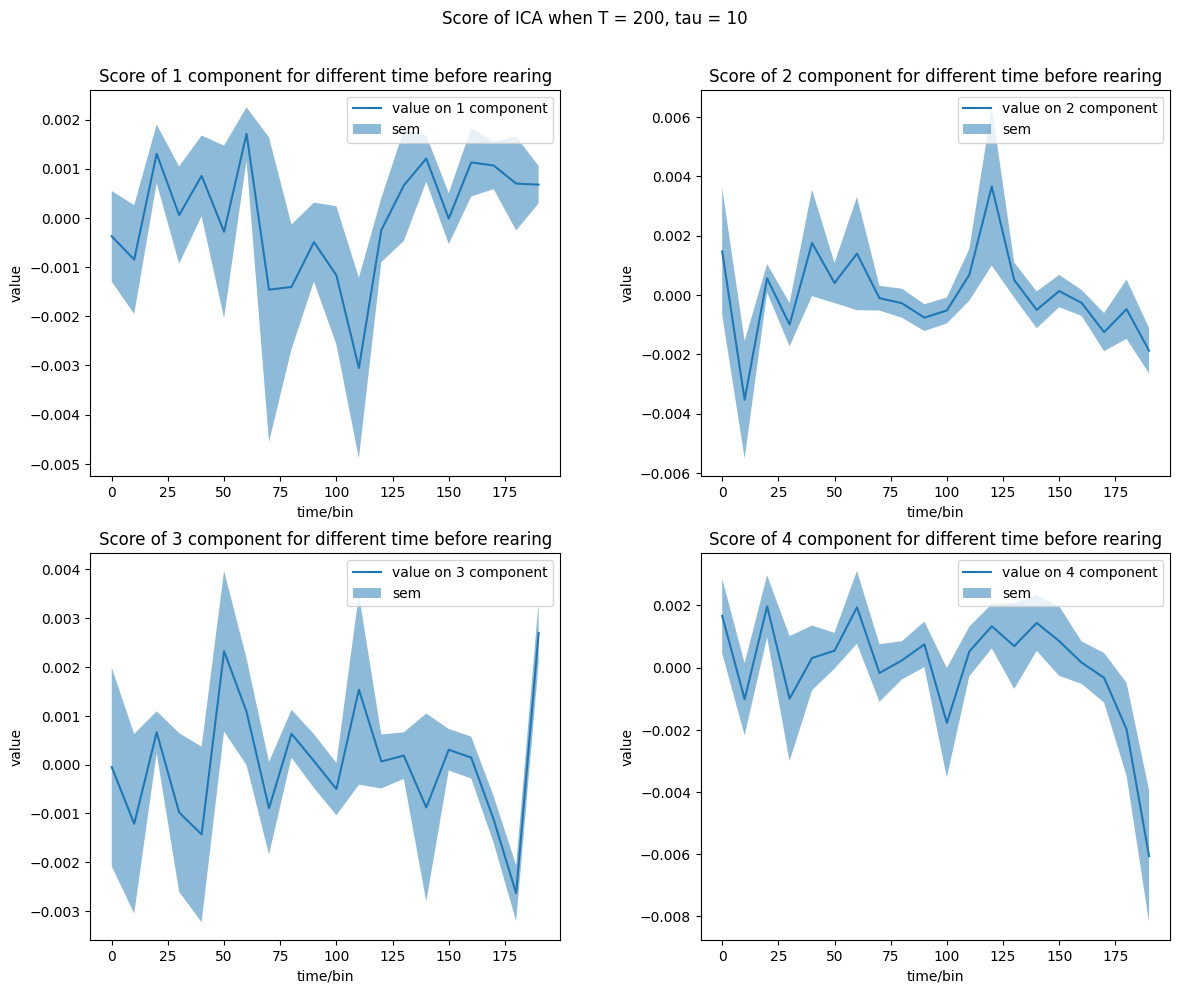

In [114]:
feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (12,10))
axis = axis.flatten()



fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,hspace=0.2, wspace=0.3)

interested_comp = [4,5,6,7]
for i, comp in enumerate(interested_comp):
    reshape_x = np.reshape(S_[:,comp].reshape(-1),(-1, num_events))
    x_sem = sem(reshape_x, axis = 1)        

    # plot the results
    x = np.arange(0,int(T//tau))*tau

    axis[i].plot(x, reshape_x.mean(axis = 1), label = 'value on %d component'%(i+1))
    axis[i].fill_between(x, reshape_x.mean(axis = 1) + x_sem, reshape_x.mean(axis = 1)- x_sem, alpha = 0.5, label = 'sem')
    axis[i].set_xlabel('time/bin')
    axis[i].set_ylabel('value')
    axis[i].set_title('Score of %d component for different time before rearing'%(i+1))
    axis[i].legend()
fig.suptitle('Score of ICA when T = %d, tau = %d'%(T, tau))


In [89]:
ica.

(40, 40)

Text(0.5, 0.98, ' ICA sec component when T = 200, tau = 10')

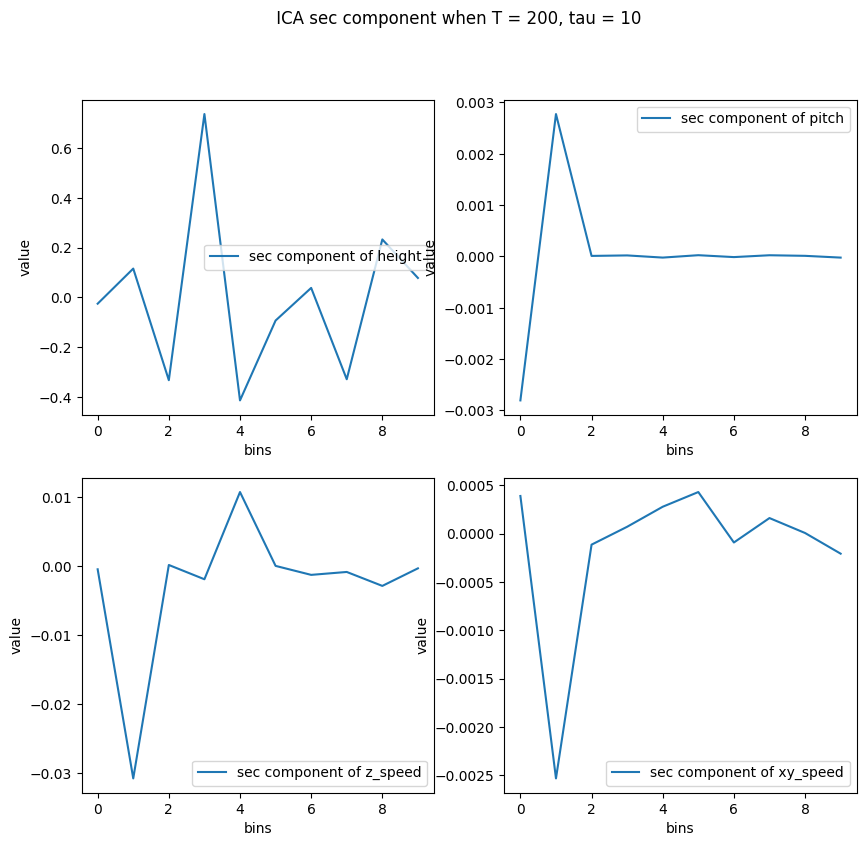

In [113]:

# Plot eigenvector resutls for first PC,

feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (10,9))
axis = axis.flatten()
k = 4
firt_pc = np.split(ica.components_[1,:], k, axis = 0)

for i in np.arange(0,k):
   
    axis[i].plot(firt_pc[i],label = 'sec component of %s'%feature_labels[i])

    axis[i].legend()
    axis[i].set_xlabel('bins',)
    axis[i].set_ylabel('value')
fig.suptitle(' ICA sec component when T = 200, tau = 10')

In [66]:
save_fig = True # to save the fig

(3740, 40)


/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_17341/910292327.py:25: RuntimeWarning: divide by zero encountered in log
  this_heatmap = axis[i].imshow(np.log(this_joint_array), cmap = 'rainbow', interpolation='none',aspect='auto', extent=[this_xline[0],this_xline[-1],this_yline[0],this_yline[-1]])


(3740, 40)


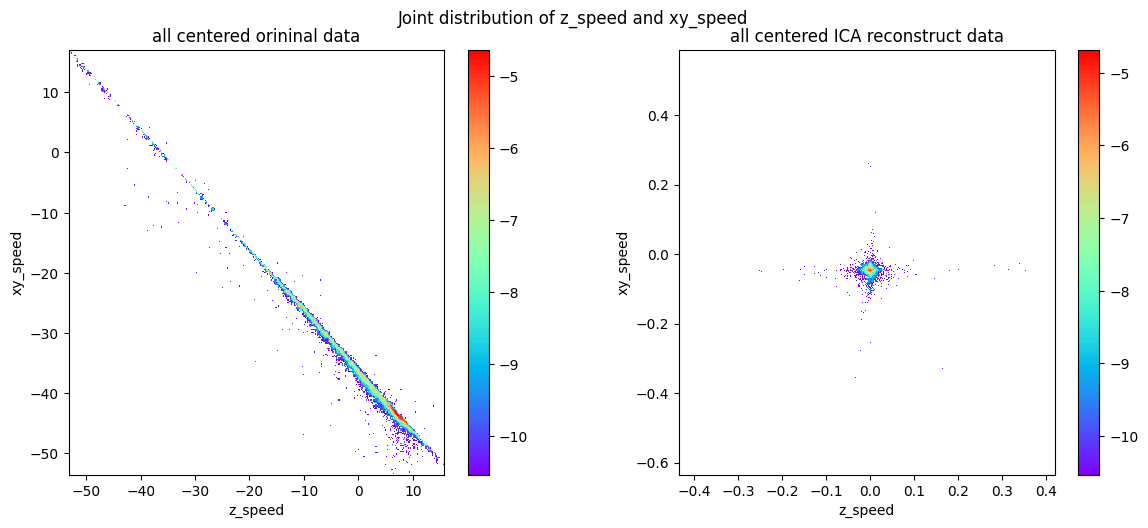

In [97]:
# calculate the joint probability distribution of two variables
this_tau = 10
this_T = 200
fir_idx, sec_idx = int(2),int(3) # height, pitch


feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(1,2, figsize = (12,5))
axis = axis.flatten()



fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,hspace=0.2, wspace=0.3)

list_steps = [[0.2,0.2],[0.001,0.001]]
labels = ['all centered orininal','all centered ICA reconstruct']

for i,this_X in enumerate([x_norm, S_]):
        print(S_.shape)
        this_fir_feature = this_X[:, fir_idx* this_tau: (fir_idx+1) * this_tau].reshape(-1)
        this_sec_feature = this_X[:, sec_idx* this_tau: (sec_idx+1) * this_tau].reshape(-1)
        
        [this_xline, this_yline], this_joint_array = joint_density_function(this_fir_feature, this_sec_feature, steps = list_steps[i], set_max= False, set_min= False)
        
        this_heatmap = axis[i].imshow(np.log(this_joint_array), cmap = 'rainbow', interpolation='none',aspect='auto', extent=[this_xline[0],this_xline[-1],this_yline[0],this_yline[-1]])
        axis[i].set_xlabel('%s'%feature_labels[fir_idx])
        axis[i].set_ylabel('%s'% feature_labels[sec_idx])
        fig.colorbar(this_heatmap, ax =axis[i])
        axis[i].set_title('%s data'%(labels[i]))

this_title = 'Joint distribution of %s and %s'%(feature_labels[fir_idx], feature_labels[sec_idx])
fig.suptitle(this_title)
if save_fig == True:
        fig.savefig('results/ICA_method/%s/%s.png'%(rat_id, this_title), format ='png',)
